In [1]:
import sklearn
import pandas as pd
import numpy as np
import json
from matplotlib.legend_handler import HandlerLine2D
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report, auc, roc_curve
from imblearn.pipeline import Pipeline as pipe

In [3]:
# Importando o arquivo JSON, no meu caso está no mesmo path que o notebook
json_dados = json.load(open('challenge.json')) 

In [4]:
df = pd.DataFrame(json_dados)
df.head()

,customer_code,branch_id,sales_channel,seller_code,register_date,total_price,order_id,quantity,item_code,item_total_price,unit_price,group_code,segment_code,is_churn
0,143,0,0,190,2017-11-10T00:00:00Z,1613.53,21804,10,854,292.91,25.04,0,0,0
1,433,0,1,153,2011-05-16T00:00:00Z,11163.69,5486,20,246,287.19,12.33,0,5,0
2,486,0,0,166,2018-01-24T00:00:00Z,6432.12,22662,12,1420,184.84,12.80,0,0,0
3,107,0,1,156,2010-07-28T00:00:00Z,831.82,3956,18,1963,189.18,10.51,0,0,0
4,768,0,1,218,2010-12-17T00:00:00Z,1736.48,4730,5,1786,66.87,11.82,0,0,0


In [5]:
#Importando datetime atual
now = datetime.datetime.now()

In [6]:
df['date'] = pd.to_datetime(df['register_date'])
df['date_notz'] = df['date'].dt.tz_localize(None)

In [7]:
df['years_active'] = ((now - df['date_notz']).dt.days)/365.0

In [8]:
#Retirada de colunas que nao iremos utilizar
df_drop = df.drop(['customer_code', 'order_id', 'register_date','date', 'date_notz'],axis=1)
df_drop = df_drop.drop('branch_id',axis=1)
df_drop.head()

,sales_channel,seller_code,total_price,quantity,item_code,item_total_price,unit_price,group_code,segment_code,is_churn,years_active
0,0,190,1613.53,10,854,292.91,25.04,0,0,0,3.402740
1,1,153,11163.69,20,246,287.19,12.33,0,5,0,9.895890
2,0,166,6432.12,12,1420,184.84,12.80,0,0,0,3.197260
3,1,156,831.82,18,1963,189.18,10.51,0,0,0,10.695890
4,1,218,1736.48,5,1786,66.87,11.82,0,0,0,10.306849


In [9]:
#Verificando quantos codigos unidos de item tempos na coluna item_code
len(df_drop['item_code'].unique())

2981

### Como o maior interesse da TOTVS é em cálculo de churn, utilizarei esta variável para análise, porém antes devemos separas as bases de treino e teste.

In [10]:
train_df = df_drop.sample(frac=0.75, random_state=1019)
test_df = df_drop.drop(train_df.index)

In [11]:
train_df['item_code'][train_df['item_code'] < train_df['item_code'].quantile(0.68)] = 'Unknown'

<ipython-input-11-1f249ec772f3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['item_code'][train_df['item_code'] < train_df['item_code'].quantile(0.68)] = 'Unknown'


In [12]:
train_df['sales_channel'][train_df['sales_channel'] < train_df['sales_channel'].quantile(0.68)] = 'Unknown'

<ipython-input-12-0451b789620b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['sales_channel'][train_df['sales_channel'] < train_df['sales_channel'].quantile(0.68)] = 'Unknown'


In [13]:
train_df['seller_code'][train_df['seller_code'] < train_df['seller_code'].quantile(0.68)] = 'Unknown'

<ipython-input-13-1d0b167b2c92>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['seller_code'][train_df['seller_code'] < train_df['seller_code'].quantile(0.68)] = 'Unknown'


In [14]:
train_df.head()

,sales_channel,seller_code,total_price,quantity,item_code,item_total_price,unit_price,group_code,segment_code,is_churn,years_active
64272,Unknown,201,2400.09,1,Unknown,59.81,59.81,0,5,0,7.000000
161495,7,Unknown,489.75,5,Unknown,320.70,56.32,2,2,1,4.698630
26892,2,190,539.11,3,Unknown,4.62,1.54,2,2,1,9.775342
124690,7,Unknown,1085.70,5,Unknown,320.70,56.32,2,2,1,5.364384
14753,Unknown,Unknown,2804.63,4,Unknown,119.88,29.97,0,0,0,3.600000


In [15]:
len(train_df['item_code'].unique())

1034

In [16]:
#Criação da funcao do dicionário com os valores de churn
def churn_dict(col,df):
    #Uso apenas do codigo de treino
    churn_rate = {}
    
    for uid, grp in df.groupby(col):
        uid = str(uid)
        churn_rate[uid] = float(len(grp[grp.is_churn == '1'])) / float(len(grp)) #churn rate
    
    return churn_rate

In [17]:
item_dict = churn_dict('item_code',train_df)
channel_dict = churn_dict('sales_channel',train_df)
seller_dict = churn_dict('seller_code',train_df)

In [18]:
#aplicacao de mascara nas colunas
seller_code_masked = train_df['seller_code'].astype(str).replace(seller_dict)
train_df['seller_code'] = seller_code_masked

In [19]:
item_code_masked = train_df['item_code'].astype(str).replace(item_dict)
train_df['item_code'] = item_code_masked

In [20]:
channel_code_masked = train_df['sales_channel'].astype(str).replace(channel_dict)
train_df['sales_channel'] = channel_code_masked

In [21]:
#aplicacao de mascara nas colunas agora de teste
seller_code_masked_test = test_df['seller_code'].astype(str).replace(seller_dict)
item_code_masked_test = test_df['item_code'].astype(str).replace(item_dict)
channel_code_masked_test = test_df['sales_channel'].astype(str).replace(channel_dict)

In [22]:
test_df['seller_code'] = [seller_dict['Unknown'] if i > 1.0 else i for i in seller_code_masked_test]
test_df['item_code'] = [seller_dict['Unknown'] if i > 1.0 else i for i in item_code_masked_test]
test_df['channel_code'] = [seller_dict['Unknown'] if i > 1.0 else i for i in channel_code_masked_test]

# Aplicação da regressão Logística

In [23]:
# isolando a variavel desejada
y_train = train_df['is_churn'].values 
X_train = train_df.drop('is_churn',axis=1)

In [24]:
y_train = [0 if i is None else i for i in y_train] #eliminando nulos
y_train = [int(i) for i in y_train] #check de tipagem, deve ser numero

In [25]:
# isolando a variavel desejada, agora na amostra de teste
y_test = test_df['is_churn'].values
X_test = test_df.drop('is_churn',axis=1)

In [26]:
y_test = [0 if i is None else i for i in y_test] #eliminando nulos
y_test = [int(i) for i in y_test] #check de tipagem, deve ser numero

In [27]:
def transform_pipeline(cols):
    
    si_step = ('si',SimpleImputer(strategy='median'))

    steps = [si_step]
    trans_pipe = Pipeline(steps)

    transformers = [('all_cols', trans_pipe, cols)]
    
    ct = ColumnTransformer(transformers=transformers)
    return ct

In [28]:
cols = list(X_train.columns)

In [29]:
#transformando dados com simplute imputer
ct = transform_pipeline(cols)

In [30]:
# Transformando dados de teste e treino
X_train_trans = ct.fit_transform(X_train)
X_test_trans = ct.transform(X_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "


In [31]:
learning_rates = [1.5, 1, 0.5, 0.25, 0.1, 0.05, 0.01]
train_results = []
test_results = []
for eta in learning_rates:
    model = GradientBoostingClassifier(learning_rate=eta)
    model.fit(X_train_trans, y_train)
    train_pred = model.predict(X_train_trans)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = model.predict(X_test_trans)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)

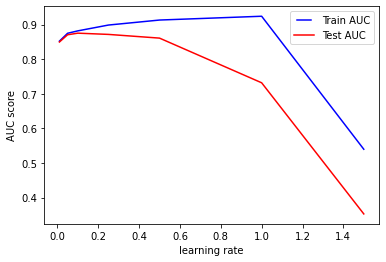

In [32]:
line1, = plt.plot(learning_rates, train_results, 'b', label='Train AUC')
line2, = plt.plot(learning_rates, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('learning rate')
plt.show()

In [33]:
best_rate = 0.05

In [34]:
estimators = [1,2,4,8,16,32,64,100,200]
train_results = []
test_results = []
for est in estimators:
    model = GradientBoostingClassifier(n_estimators=est)
    model.fit(X_train_trans, y_train)
    train_pred = model.predict(X_train_trans)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = model.predict(X_test_trans)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)

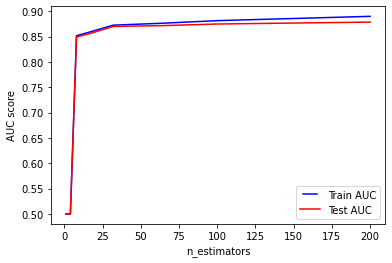

In [35]:
line1, = plt.plot(estimators, train_results, 'b', label='Train AUC')
line2, = plt.plot(estimators, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('n_estimators')
plt.show()

In [36]:
best_est = 32

In [37]:
min_splits = np.linspace(0.1,1.0,10,endpoint=True)
train_results = []
test_results = []
for split in min_splits:
    model = GradientBoostingClassifier(min_samples_split=split)
    model.fit(X_train_trans, y_train)
    train_pred = model.predict(X_train_trans)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = model.predict(X_test_trans)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)

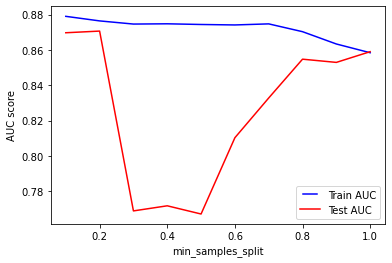

In [38]:
line1, = plt.plot(min_splits, train_results, 'b', label='Train AUC')
line2, = plt.plot(min_splits, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('min_samples_split')
plt.show()

In [39]:
best_split = 0.2

In [40]:
min_samples_leafs = np.linspace(0.1,0.5,5,endpoint=True)
train_results = []
test_results = []
for leaf in min_samples_leafs:
    model = GradientBoostingClassifier(min_samples_leaf=leaf)
    model.fit(X_train_trans, y_train)
    train_pred = model.predict(X_train_trans)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = model.predict(X_test_trans)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)

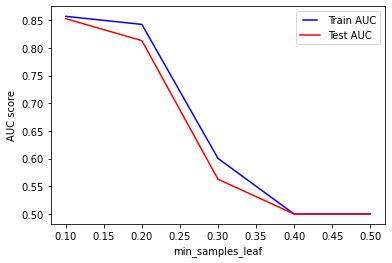

In [41]:
line1, = plt.plot(min_samples_leafs, train_results, 'b', label='Train AUC')
line2, = plt.plot(min_samples_leafs, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('min_samples_leaf')
plt.show()

In [42]:
best_leaf = 0.15

In [43]:
# criando o pipeline de ml com os parametros acima
def ml_pipeline():
    ss_step = ('ss', StandardScaler(with_mean=True))

    gb_step = ('gb',GradientBoostingClassifier(learning_rate = 0.05,
                                              n_estimators=best_est,
                                              max_depth=5, 
                            # i chose a max_depth automatically based on experience and time constraints
                                              min_samples_split=best_split,
                                              min_samples_leaf=best_leaf))
    
    pipeline_steps = [ss_step, gb_step]
    
    ml_pipe = pipe(pipeline_steps)
    
    return ml_pipe

In [44]:
ml_pipe = ml_pipeline()

In [45]:
#aplicando fit no treino
ml_pipe.fit(X_train_trans,y_train)

Pipeline(steps=[('ss', StandardScaler()),
                ('gb',
                 GradientBoostingClassifier(learning_rate=0.05, max_depth=5,
                                            min_samples_leaf=0.15,
                                            min_samples_split=0.2,
                                            n_estimators=32))])

In [46]:
#predict na base teste
y_pred = ml_pipe.predict(X_test_trans)
y_prob = ml_pipe.predict_proba(X_test_trans)[:,1]

In [47]:
cr = classification_report(y_test,y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.93      0.96      0.95     41459
           1       0.80      0.71      0.75      9648

    accuracy                           0.91     51107
   macro avg       0.87      0.83      0.85     51107
weighted avg       0.91      0.91      0.91     51107



In [48]:
# Definiçao da matrix de confusao
cm = confusion_matrix(y_test,y_pred)
print(cm)

[[39753  1706]
 [ 2791  6857]]


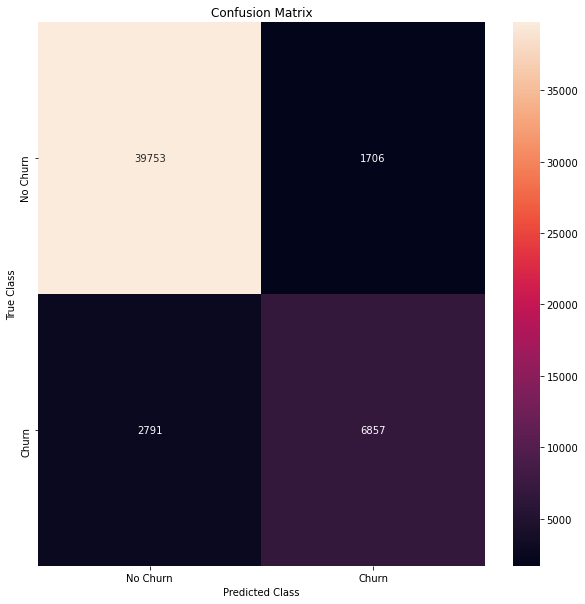

In [49]:
def plot_cm(cm):
    labels = ['No Churn','Churn']
    plt.figure(figsize=(10,10))
    sns.heatmap(cm,xticklabels=labels,yticklabels=labels,annot=True,fmt='d')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Class')
    plt.ylabel('True Class')
    plt.show

plot_cm(cm)

In [50]:
fpr, tpr, thresholds = roc_curve(y_test,y_prob)
roc_auc = auc(fpr,tpr)

In [51]:
def plot_roc(fpr, tpr, thresholds,roc_auc):
    plt.figure(figsize=(15,8))
    plt.title('Receiver Operating Characteristic AUC')
    plt.plot(fpr,tpr,'b',label='AUC = %0.2f'%roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.1,1.1])
    plt.ylim([-0.1,1.1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()

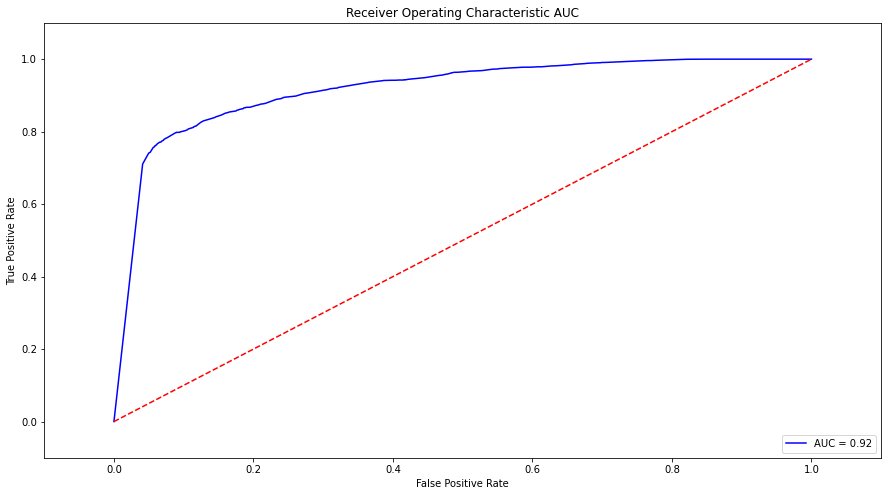

In [52]:
plot_roc(fpr, tpr, thresholds,roc_auc)

### Realizamos diversas operações com a variável escolhida e diversas visualizacoes utilizando diversas bibs, precisariamos de mais tempo para explorar falsos positivos e melhorar o modelo aos poucos.